<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Figura_en_2D_con_apoyo_movil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Condición numérica de K_red: 2.26e+16

¡Advertencia! Matriz mal condicionada. Usando pseudoinversa


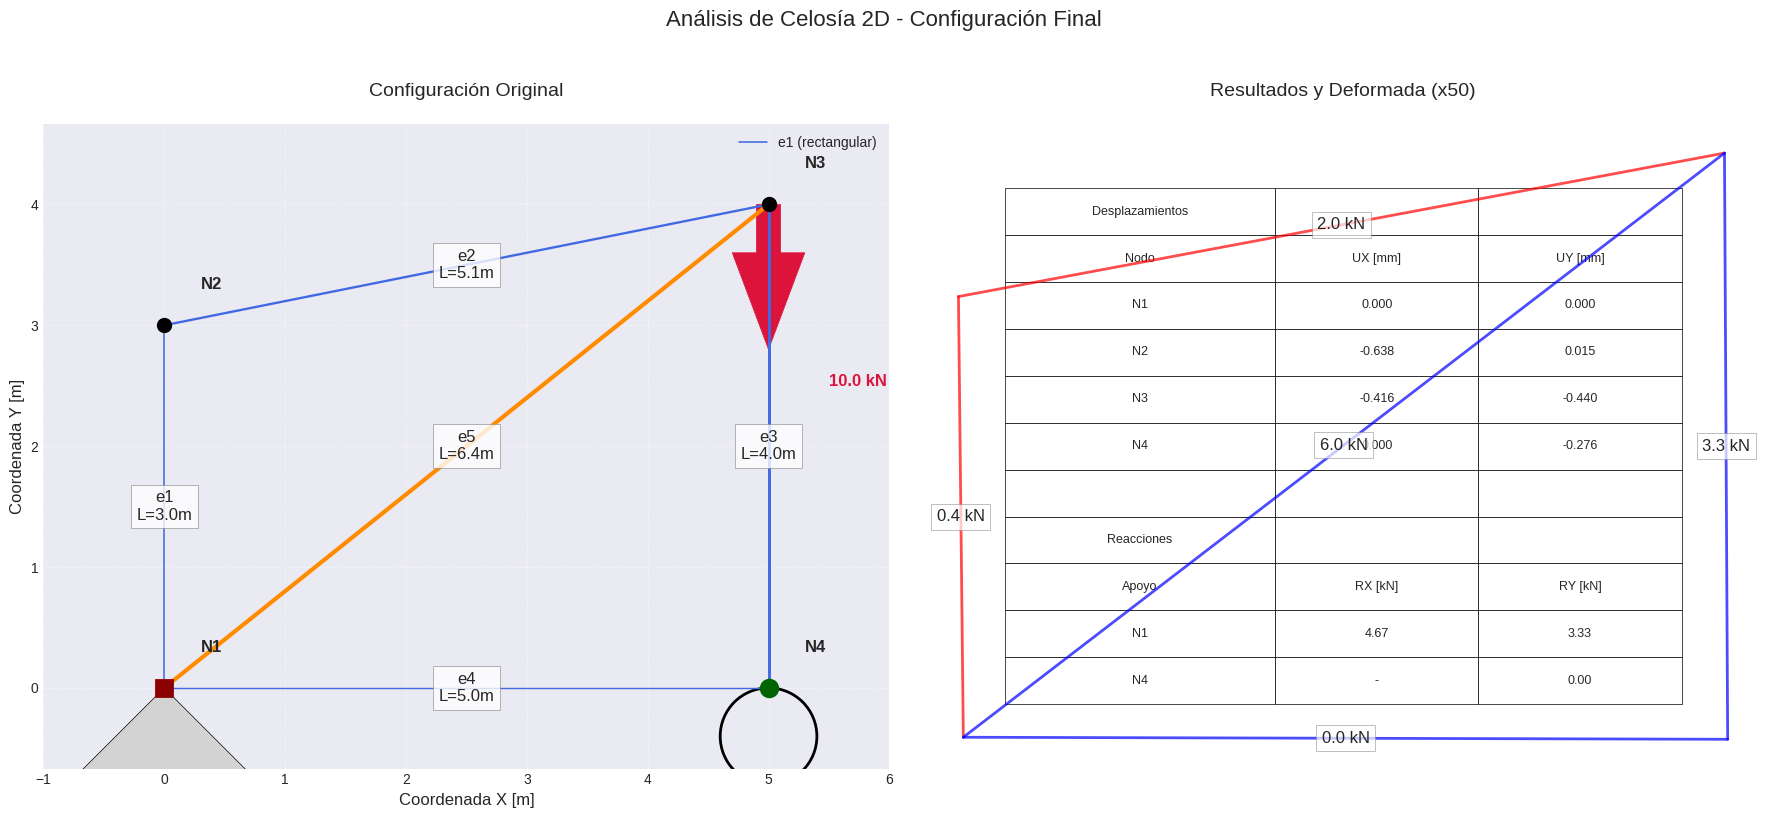

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon, FancyArrow
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# =============================================
# **1. CONFIGURACIÓN INICIAL**
# =============================================

plt.style.use('seaborn-v0_8-darkgrid')

# Propiedades del material (Acero)
E = 2.05e11  # Módulo de elasticidad [Pa]

# Geometría de secciones [m]
b_rect, h_rect, t_rect = 0.10, 0.10, 0.001  # Barras rectangulares
d_circ, t_circ = 0.10, 0.001  # Barra circular

# Cálculo de áreas
A_rect = (b_rect * h_rect) - ((b_rect - 2*t_rect) * (h_rect - 2*t_rect))
A_circ = np.pi * ((d_circ/2)**2 - (d_circ/2 - t_circ)**2)

# =============================================
# **2. GEOMETRÍA EXACTA CON APOYOS EN NODOS 1 Y 4**
# =============================================

# Definición de nodos [m]
nodos = {
    1: [0.0, 0.0],   # Nodo 1 (Apoyo fijo)
    2: [0.0, 3.0],   # Nodo 2
    3: [5.0, 4.0],   # Nodo 3 (Punto de carga)
    4: [5.0, 0.0]    # Nodo 4 (Apoyo móvil)
}

# Definición de elementos (sin barra entre e2 y e4)
elementos = [
    [1, 2, A_rect, 'e1', 3.0, 'rectangular'],   # Barra vertical izquierda (N1-N2)
    [2, 3, A_rect, 'e2', np.sqrt(5**2 + 1**2), 'rectangular'],  # Barra diagonal (N2-N3)
    [3, 4, A_rect, 'e3', 4.0, 'rectangular'],   # Barra vertical derecha (N3-N4)
    [1, 4, A_rect, 'e4', 5.0, 'rectangular'],   # Barra horizontal inferior (N1-N4)
    [1, 3, A_circ, 'e5', np.sqrt(5**2 + 4**2), 'circular']  # Barra diagonal principal (N1-N3)
]

# Carga aplicada [N] en nodo 3 hacia abajo
F_magnitud = 10000  # 10 kN

# =============================================
# **3. ANÁLISIS ESTRUCTURAL**
# =============================================

n_nodos = len(nodos)
n_gdl = 2 * n_nodos  # 2 grados de libertad por nodo

# Matriz de rigidez global
K = np.zeros((n_gdl, n_gdl))
for ni, nj, A, name, L, tipo in elementos:
    xi, yi = nodos[ni]
    xj, yj = nodos[nj]
    c = (xj - xi)/L
    s = (yj - yi)/L

    # Matriz de rigidez local
    k = (E*A/L) * np.array([
        [c*c, c*s, -c*c, -c*s],
        [c*s, s*s, -c*s, -s*s],
        [-c*c, -c*s, c*c, c*s],
        [-c*s, -s*s, c*s, s*s]
    ])

    # Ensamblaje
    gdl = [2*(ni-1), 2*(ni-1)+1, 2*(nj-1), 2*(nj-1)+1]
    for i, gi in enumerate(gdl):
        for j, gj in enumerate(gdl):
            K[gi, gj] += k[i, j]

# Vector de fuerzas (nodo 3 hacia abajo)
F = np.zeros(n_gdl)
F[2*3-1] = -F_magnitud  # Fuerza vertical en nodo 3

# Restricciones (nodo 1 fijo, nodo 4 móvil vertical)
gdl_restringidos = [0, 1, 6]  # ux1=0, uy1=0, uy4=0

# Verificación de estabilidad
K_red = np.delete(np.delete(K, gdl_restringidos, axis=0), gdl_restringidos, axis=1)
F_red = np.delete(F, gdl_restringidos)

condicion = np.linalg.cond(K_red)
print(f"Condición numérica de K_red: {condicion:.2e}")

if condicion > 1e10:
    print("\n¡Advertencia! Matriz mal condicionada. Usando pseudoinversa")
    U_red = np.linalg.pinv(K_red) @ F_red
else:
    U_red = np.linalg.solve(K_red, F_red)

# Desplazamientos completos
U = np.zeros(n_gdl)
j = 0
for i in range(n_gdl):
    if i not in gdl_restringidos:
        U[i] = U_red[j]
        j += 1

# Reacciones
R = K @ U - F

# Fuerzas axiales
fuerzas_axiales = []
for ni, nj, A, name, L, tipo in elementos:
    ui = U[2*(ni-1):2*(ni-1)+2]
    uj = U[2*(nj-1):2*(nj-1)+2]
    c = (nodos[nj][0] - nodos[ni][0])/L
    s = (nodos[nj][1] - nodos[ni][1])/L
    ε = (-c*ui[0] - s*ui[1] + c*uj[0] + s*uj[1])/L
    N = E * ε * A
    fuerzas_axiales.append((name, N, tipo))

# =============================================
# **4. VISUALIZACIÓN AVANZADA**
# =============================================

fig = plt.figure(figsize=(18, 8))
fig.suptitle('Análisis de Celosía 2D - Configuración Final', fontsize=16, y=1.02)

# Subplot 1: Estructura original
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Configuración Original', pad=20)

# Paleta de colores para tipos de barras
cmap = {'rectangular': 'royalblue', 'circular': 'darkorange'}

for (ni, nj, _, name, L, tipo), (_, N, _) in zip(elementos, fuerzas_axiales):
    xi, yi = nodos[ni]
    xj, yj = nodos[nj]
    linewidth = 1 + 2 * abs(N) / max(abs(f[1]) for f in fuerzas_axiales)

    ax1.plot([xi, xj], [yi, yj], '-',
             color=cmap[tipo],
             lw=linewidth,
             label=f'{name} ({tipo})' if name == 'e1' else "")

    mid_x, mid_y = (xi+xj)/2, (yi+yj)/2
    ax1.text(mid_x, mid_y, f'{name}\nL={L:.1f}m',
             ha='center', va='center',
             backgroundcolor='white',
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# Dibujar nodos y apoyos
for i, (x, y) in nodos.items():
    if i in [1, 4]:  # Apoyos
        color = 'darkred' if i == 1 else 'darkgreen'
        marker = 's' if i == 1 else 'o'
        ax1.plot(x, y, marker, color=color, markersize=12, markeredgewidth=2)

        # Símbolo de apoyo
        if i == 1:  # Apoyo fijo
            ax1.add_patch(Polygon([[x-0.8, y-0.8], [x+0.8, y-0.8], [x, y]],
                         facecolor='lightgray', edgecolor='black'))
        else:  # Apoyo móvil (nodo 4)
            ax1.add_patch(Circle((x, y-0.4), 0.4, fill=False, lw=2, color='black'))
    else:
        ax1.plot(x, y, 'o', color='black', markersize=10)

    ax1.text(x + 0.3, y + 0.3, f'N{i}', fontsize=12, weight='bold')

# Dibujar carga
load_arrow = FancyArrow(nodos[3][0], nodos[3][1],
                      0, -1.2, width=0.2, head_width=0.6, head_length=0.8,
                      color='crimson', length_includes_head=True)
ax1.add_patch(load_arrow)
ax1.text(nodos[3][0] + 0.5, nodos[3][1] - 1.5, f'{F_magnitud/1000:.1f} kN',
        color='crimson', fontsize=12, weight='bold')

ax1.set_xlabel('Coordenada X [m]')
ax1.set_ylabel('Coordenada Y [m]')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.axis('equal')
ax1.set_xlim(-1, 6)
ax1.set_ylim(-1, 5)
ax1.legend(loc='upper right')

# Subplot 2: Resultados y deformada
ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Resultados y Deformada (x50)', pad=20)

# Dibujar estructura deformada
factor_def = 50
for (ni, nj, _, name, L, tipo), (_, N, _) in zip(elementos, fuerzas_axiales):
    xi, yi = nodos[ni]
    xj, yj = nodos[nj]
    xi_def = xi + U[2*(ni-1)] * factor_def
    yi_def = yi + U[2*(ni-1)+1] * factor_def
    xj_def = xj + U[2*(nj-1)] * factor_def
    yj_def = yj + U[2*(nj-1)+1] * factor_def

    color = 'red' if N > 0 else 'blue'  # Tracción rojo, compresión azul
    ax2.plot([xi_def, xj_def], [yi_def, yj_def], '-',
             color=color, lw=2, alpha=0.7)

    # Etiqueta de fuerza
    ax2.text((xi_def+xj_def)/2, (yi_def+yj_def)/2,
             f'{abs(N)/1000:.1f} kN',
             ha='center', va='center',
             backgroundcolor='white',
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))

# Tabla de resultados
results = [
    ['Desplazamientos', '', ''],
    ['Nodo', 'UX [mm]', 'UY [mm]'],
    *[[f'N{i}', f'{U[2*(i-1)]*1000:.3f}', f'{U[2*(i-1)+1]*1000:.3f}'] for i in range(1, n_nodos+1)],
    ['', '', ''],
    ['Reacciones', '', ''],
    ['Apoyo', 'RX [kN]', 'RY [kN]'],
    ['N1', f'{R[0]/1000:.2f}', f'{R[1]/1000:.2f}'],
    ['N4', '-', f'{R[6]/1000:.2f}']
]

ax2.table(cellText=results,
         cellLoc='center',
         colWidths=[0.2, 0.15, 0.15],
         bbox=[0.1, 0.1, 0.8, 0.8])

ax2.axis('off')

plt.tight_layout()
plt.show()